C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 0.3786 - loss: 1.4709 - val_accuracy: 0.4225 - val_loss: 1.0771
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.4432 - loss: 1.0707 - val_accuracy: 0.4225 - val_loss: 1.0771
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.4494 - loss: 1.0674 - val_accuracy: 0.4225 - val_loss: 1.0773
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.4437 - loss: 1.0736 - val_accuracy: 0.4225 - val_loss: 1.0789


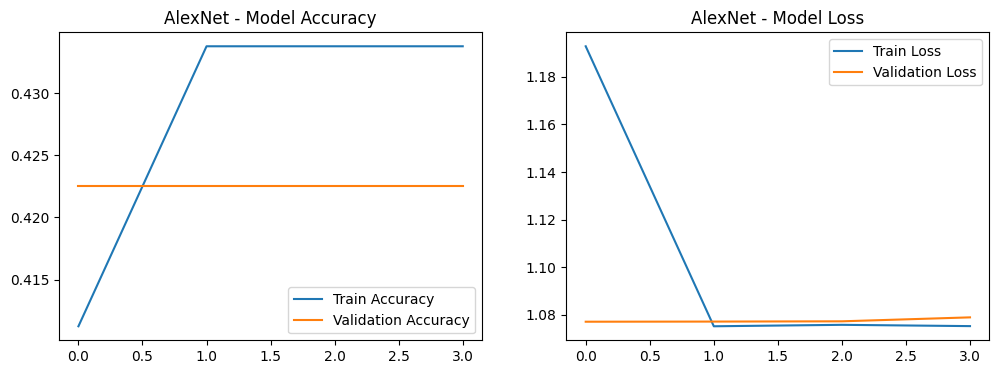

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step 


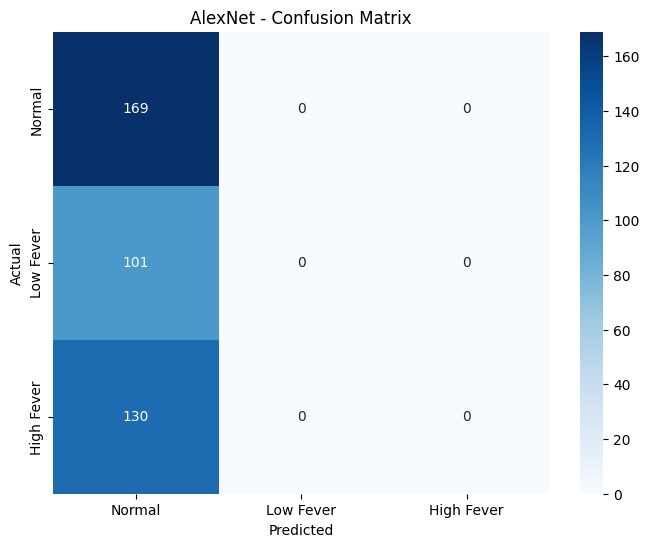

AlexNet - Classification Report
              precision    recall  f1-score   support

      Normal       0.42      1.00      0.59       169
   Low Fever       0.00      0.00      0.00       101
  High Fever       0.00      0.00      0.00       130

    accuracy                           0.42       400
   macro avg       0.14      0.33      0.20       400
weighted avg       0.18      0.42      0.25       400



C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate synthetic data
def generate_data():
    temperatures = np.random.uniform(35, 41, size=2000)
    labels = []
    for temp in temperatures:
        if temp < 37.5:
            labels.append(0)  # Normal
        elif 37.5 <= temp < 39:
            labels.append(1)  # Low Fever
        else:
            labels.append(2)  # High Fever
    data = pd.DataFrame({"Temperature": temperatures, "Label": labels})
    return data

# Create synthetic data and save it
data = generate_data()
data.to_csv("temperature_data.csv", index=False)

# Load the data
data = pd.read_csv("temperature_data.csv")
X = data["Temperature"].values
y = data["Label"].values

# Preprocess data into image-like format
X = np.array([[[[temp] * 128] * 128 for temp in X]])
X = X.reshape(-1, 128, 128, 1)  # Reshape to (samples, height, width, channels)
X = np.repeat(X, 3, axis=-1)  # Convert to 3 channels

# Normalize the data
X = X / 41.0  # Normalize based on the max temperature value

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define AlexNet-like architecture
model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Normal, Low Fever, High Fever
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Save the trained model
model.save('alexnet_temperature_model.h5')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet - Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AlexNet - Model Loss')
plt.legend()

plt.show()

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Low Fever', 'High Fever'],
            yticklabels=['Normal', 'Low Fever', 'High Fever'])
plt.title('AlexNet - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print('AlexNet - Classification Report')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Low Fever', 'High Fever']))


In [1]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('alexnet_temperature_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply optimizations
tflite_model = converter.convert()

# Save the TFLite model
with open('alexnet_temperature_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\eshwa\AppData\Local\Temp\tmpwoa26gnr\assets


INFO:tensorflow:Assets written to: C:\Users\eshwa\AppData\Local\Temp\tmpwoa26gnr\assets


Saved artifact at 'C:\Users\eshwa\AppData\Local\Temp\tmpwoa26gnr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1584453426960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453427728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453428880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453427344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453431184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453431952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453431760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453432144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453432720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1584453433296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  158445